In [11]:
from imports.models import *
from imports.utils import *
import adabound as Adabound

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import glob, os, sys
import time
import copy
np.set_printoptions(suppress=True)

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import shuffle
import itertools

___
### At first, it'll generate simulation CPMG data for the denosing model.

Practically, it needs more data. Just for this turorial, it'll generate a small number of samples. (training samples: 8192*4, validation sample: 8192)

In [2]:
time_resolution = 0.004
time_data = np.arange(0, 60, time_resolution)

MAGNETIC_FIELD = 403.553
GYRO_MAGNETIC_RATIO = 1.07*1000       # Unit: Herts
WL_VALUE = MAGNETIC_FIELD*GYRO_MAGNETIC_RATIO*2*np.pi
N_PULSE_32 = 32
N_PULSE_256 = 256

SAVE_MLISTS = './'

N_SAMPLES_TRAIN = 8192*128
N_SAMPLES_VALID = 8192
data_size = 1024
GPU_INDEX = '0'

___
This is for making gaussian slope in simulated data.

In [3]:
def gaussian_slope(time_data, time_index, px_mean_value_at_time, M_list=None):
    m_value_at_time = (px_mean_value_at_time * 2) - 1
    Gaussian_co = -time_data[time_index] / np.log(m_value_at_time)

    slope = np.exp(-(time_data / Gaussian_co)**2)
    if M_list != None:
        M_list_slope = M_list * slope
        px_list_slope = (1 + M_list_slope) / 2
        return px_list_slope, slope
    return slope

SLOPE_INDEX = 11812
MEAN_PX_VALUE = np.linspace(0.65, 0.94, 20) 
slope = {} 
for idx, mean_px_value in enumerate(MEAN_PX_VALUE):
    slope[idx] = gaussian_slope(time_data[:24000], SLOPE_INDEX, mean_px_value, None)

___
Parameters to generate (A, B) lists.
Maximum and minimum ranges in (A, B) values are determined w.r.t. distributions of nuclear spins in diamond. Roughly saying, the farther the distance from NV center is, the weaker the hyperfine interaction is, which means nuclear spins with smaller (A, B) values are distributed much more than nuclear spins with larger (A, B) values. 

: It can still be modified for better representation of accurate distributions of (A, B).

In [4]:
#### Range of A & B (Hz)
A_search_min = -80000
A_search_max = 80000          
B_search_min = 2000
B_search_max = 100000          
A_steps = 500                           
B_steps = 500                          

n_A_samples = (A_search_max - A_search_min) // A_steps
n_B_samples = (B_search_max - B_search_min) // B_steps

TOTAL_TEST_ARRAY = np.zeros((n_A_samples * n_B_samples, 2))

In [5]:
B_FIXED_VALUE = B_search_min
for i in range(n_B_samples):
    test_array = np.array([np.arange(A_search_min, A_search_max, A_steps), np.full((n_A_samples,), B_FIXED_VALUE)])
    test_array = test_array.transpose()
    test_array = np.round(test_array,2)
    TOTAL_TEST_ARRAY[i*n_A_samples:(i+1)*n_A_samples] = test_array
    B_FIXED_VALUE += B_steps

In [63]:
A_candidate_max = 80000
A_candidate_min = -80000
B_candidate_max = 90000
B_candidate_min = 2000

A_small_max = 70000
A_small_min = -70000
B_small_max = 15000
B_small_min = 2000

candidate_boolen_index = ((TOTAL_TEST_ARRAY[:,1]>=B_candidate_min) & (TOTAL_TEST_ARRAY[:,1]<=B_candidate_max))   \
                        & ((TOTAL_TEST_ARRAY[:,0]>=A_candidate_min) & (TOTAL_TEST_ARRAY[:,0]<=A_candidate_max)) 
AB_candidate_array = TOTAL_TEST_ARRAY[candidate_boolen_index]

small_AB_boolen_index = ((TOTAL_TEST_ARRAY[:,1]>=B_small_min) & (TOTAL_TEST_ARRAY[:,1]<=B_small_max))   \
                         & ((TOTAL_TEST_ARRAY[:,0]>=A_small_min) & (TOTAL_TEST_ARRAY[:,0]<=A_small_max)) 
small_AB_array = TOTAL_TEST_ARRAY[small_AB_boolen_index]

AB_candidate_array *= (2 * np.pi)
small_AB_array *= (2 * np.pi)

In [64]:
n_of_cases_train = 128
n_of_samples = N_SAMPLES_TRAIN // n_of_cases_train

tic = time.time()
for i in range(n_of_cases_train):

    total_n_of_spin_lists = np.arange(24, 33)
    n_of_spins = np.random.choice(total_n_of_spin_lists)
    n_of_small_spins = n_of_spins // 2
    n_of_spins, n_of_small_spins
    
    globals()['ABlists_train_{}'.format(i)] = np.zeros((n_of_samples, n_of_spins, 2))

    for idx in range(n_of_samples):

        indices_candi = np.random.randint(len(AB_candidate_array), size=n_of_spins-n_of_small_spins)
        while len(set(indices_candi)) != (n_of_spins-n_of_small_spins):
            indices_candi = np.random.randint(len(AB_candidate_array), size=n_of_spins-n_of_small_spins)
        globals()['ABlists_train_{}'.format(i)][idx, :n_of_spins-n_of_small_spins] = AB_candidate_array[indices_candi]

        indices_candi = np.random.randint(len(small_AB_array), size=n_of_small_spins)
        while len(set(indices_candi)) != (n_of_small_spins):
            indices_candi = np.random.randint(len(small_AB_array), size=n_of_small_spins)
        globals()['ABlists_train_{}'.format(i)][idx, n_of_spins-n_of_small_spins:] = small_AB_array[indices_candi]

print("ABlists for training dataset is generated: {} s".format(round(time.time() - tic, 3)))

ABlists for training dataset is generated: 28.089 s


In [65]:
n_of_cases_valid = 32
n_of_samples = N_SAMPLES_VALID // n_of_cases_valid

tic = time.time()
for i in range(n_of_cases_valid):

    total_n_of_spin_lists = np.arange(24, 36)
    n_of_spins = np.random.choice(total_n_of_spin_lists)
    n_of_small_spins = n_of_spins // 2
    n_of_spins, n_of_small_spins
    
    globals()['ABlists_valid_{}'.format(i)] = np.zeros((n_of_samples, n_of_spins, 2))

    for idx in range(n_of_samples):

        indices_candi = np.random.randint(len(AB_candidate_array), size=n_of_spins-n_of_small_spins)
        while len(set(indices_candi)) != (n_of_spins-n_of_small_spins):
            indices_candi = np.random.randint(len(AB_candidate_array), size=n_of_spins-n_of_small_spins)
        globals()['ABlists_valid_{}'.format(i)][idx, :n_of_spins-n_of_small_spins] = AB_candidate_array[indices_candi]

        indices_candi = np.random.randint(len(small_AB_array), size=n_of_small_spins)
        while len(set(indices_candi)) != (n_of_small_spins):
            indices_candi = np.random.randint(len(small_AB_array), size=n_of_small_spins)
        globals()['ABlists_valid_{}'.format(i)][idx, n_of_spins-n_of_small_spins:] = small_AB_array[indices_candi]

print("ABlists for validation dataset is generated: {} s".format(round(time.time() - tic, 3)))

ABlists for validation dataset is generated: 0.251 s


___
### Definition the generating function for denosing datasets.
: the variable 'noise' should be set to be the experimental noise amplitude in user's experiment environment.

In [9]:

def Px_noise_data(time_table, wL_value, AB_list, n_pulse, rand_idx, data_size, y_train_pure=False):  
#     noise = 0.043                                    # Maximum Height of Noise
    noise = 0.02                                    # Maximum Height of Noise
    rescale = np.random.random()/2 + 0.75            
    noise *= rescale

    AB_list = np.array(AB_list)
    A = AB_list[:,0].reshape(len(AB_list), 1)
    B = AB_list[:,1].reshape(len(AB_list), 1)    

    w_tilda = pow(pow(A+wL_value, 2) + B*B, 1/2)  
    mz = (A + wL_value) / w_tilda                
    mx = B / w_tilda                             

    alpha = w_tilda * time_table.reshape(1, len(time_table))    
    beta = wL_value * time_table.reshape(1, len(time_table))    

    phi = np.arccos(np.cos(alpha) * np.cos(beta) - mz * np.sin(alpha) * np.sin(beta)) 
    K1 = (1 - np.cos(alpha)) * (1 - np.cos(beta))             
    K2 = 1 + np.cos(phi)                                    
    K = pow(mx,2) * (K1 / K2)                             
    M_list_temp = 1 - K * pow(np.sin(n_pulse * phi/2), 2)      
    Y_train = np.prod(M_list_temp, axis=0)                     
    
    slope_temp = np.zeros(data_size)
    if np.random.uniform() > 0.4:
        temp_idx = np.random.randint(len(slope))
        slope_temp[:data_size//3] = slope[temp_idx][rand_idx:rand_idx+data_size//3]
        temp_idx = np.random.randint(len(slope))
        slope_temp[data_size//3:2*(data_size//3)] = slope[temp_idx][rand_idx+data_size//3:rand_idx+2*(data_size//3)]
        temp_idx = np.random.randint(len(slope))
        slope_temp[2*(data_size//3):data_size] = slope[temp_idx][rand_idx+2*(data_size//3):rand_idx+data_size]
        
    else:
        temp_idx = np.random.randint(len(slope))
        slope_temp = slope[temp_idx][rand_idx:rand_idx+data_size]
    
    if y_train_pure == False:
        Y_train = (1 + slope_temp*Y_train) / 2
        X_train = Y_train + noise*(np.random.random(Y_train.shape[0]) - np.random.random(Y_train.shape[0]))
        return X_train, Y_train
    
    else:
        Y_train_pure = (1 + copy.deepcopy(Y_train)) / 2
        Y_train = (1 + slope_temp*Y_train) / 2
        X_train = Y_train + noise*(np.random.random(Y_train.shape[0]) - np.random.random(Y_train.shape[0]))
        return X_train, Y_train, Y_train_pure

In [10]:
n_of_cases = 128

X_train = np.zeros((N_SAMPLES_TRAIN, data_size))
Y_train = np.zeros((N_SAMPLES_TRAIN, data_size))
Y_train_pure = np.zeros((N_SAMPLES_TRAIN, data_size))

for i in range(n_of_cases):
    print(i, end=' ')
    for j in range(len(ABlists_train_0)):
        rand_idx = np.random.randint(11000)
        time_data_temp = time_data[rand_idx:rand_idx+data_size]
        
        X_train[i*len(ABlists_train_0)+j], \
        Y_train[i*len(ABlists_train_0)+j], \
        Y_train_pure[i*len(ABlists_train_0)+j] \
        = Px_noise_data(time_data_temp, WL_VALUE, globals()['ABlists_train_{}'.format(i)][j], N_PULSE_32, rand_idx, data_size, y_train_pure=True)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 

In [16]:
X_valid = np.zeros((N_SAMPLES_VALID, data_size))
Y_valid = np.zeros((N_SAMPLES_VALID, data_size))
Y_valid_pure = np.zeros((N_SAMPLES_VALID, data_size))

for i in range(int(N_SAMPLES_VALID/ABlists_valid_0.shape[0])):
    for j in range(len(ABlists_valid_0)):
        rand_idx = np.random.randint(11000)
        time_data_temp = time_data[rand_idx:rand_idx+data_size]

        X_valid[i*len(ABlists_valid_0)+j], \
        Y_valid[i*len(ABlists_valid_0)+j], \
        Y_valid_pure[i*len(ABlists_valid_0)+j], \
        = Px_noise_data(time_data_temp, WL_VALUE, globals()['ABlists_valid_{}'.format(i)][j], N_PULSE_32, rand_idx, data_size, y_train_pure=True)

In [6]:
# # Load
# X_train = np.load("./M_data0_X_train__Pxlist.npy")
# Y_train = np.load("./M_data0_Y_train__Pxlist.npy")
# X_valid = np.load("./M_data0_X_valid__Pxlist.npy")
# Y_valid = np.load("./M_data0_Y_valid__Pxlist.npy")


In [ ]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

In [22]:
# np.save('./X_train_deno.npy', X_train.cpu().numpy())
# np.save('./Y_train_deno.npy', Y_train.cpu().numpy())

In [7]:
X_train = np.expand_dims(X_train, axis=-2)
Y_train = np.expand_dims(Y_train, axis=-2)
X_valid = np.expand_dims(X_valid, axis=-2)
Y_valid = np.expand_dims(Y_valid, axis=-2)

In [14]:
X_train = torch.Tensor(X_train.reshape(X_train.shape[0], 2, -1)).cuda() 
Y_train = torch.Tensor(Y_train.reshape(X_train.shape[0], 2, -1)).cuda() 
X_valid = torch.Tensor(X_valid.reshape(X_valid.shape[0], 2, -1)).cuda() 
Y_valid = torch.Tensor(Y_valid.reshape(Y_valid.shape[0], 2, -1)).cuda() 

In [15]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([524288, 2, 512]),
 torch.Size([524288, 2, 512]),
 torch.Size([8192, 2, 512]),
 torch.Size([8192, 2, 512]))

____
### Now, we'll build and train denoising model.

In [16]:
model = Denoise_Model().cuda()
try:
    pred = model(X_train[:128])
    print(pred.shape) 
except:
    raise NameError("The input shape should be revised")
total_parameter = sum(p.numel() for p in model.parameters()) 
print('total_parameter: ', total_parameter / 1000000, 'M')
print(model)

torch.Size([128, 2, 512])
total_parameter:  0.03437 M
Denoise_Model(
  (conv1d_1): Conv1d(2, 64, kernel_size=(4,), stride=(1,), padding=(2,))
  (maxpooling): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1d_2): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convTrans1d_3): ConvTranspose1d(64, 64, kernel_size=(4,), stride=(2,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convTrans1d_4): ConvTranspose1d(64, 2, kernel_size=(4,), stride=(2,), padding=(1,))
  (leakyrelu): LeakyReLU(negative_slope=0.01)
)


In [17]:
SAVE_DIR = './data/denoise_models/'
try: os.mkdir(SAVE_DIR)
except: pass

In [18]:
filename = 'denoising_model_1.pt'
epochs = 100
num_train = X_train.shape[0]
mini_batch = 256
valid_mini_batch = 32
learning_rate = 0.00001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss().cuda()

total_loss = []
total_val_loss = []
for epoch in range(epochs):
    model.train() 
    avg_cost = 0
    tic = time.time() 
    
    rand_indices = np.random.randint(len(X_train), size=(num_train//mini_batch, mini_batch))

    for i in range(num_train // mini_batch):
        optimizer.zero_grad() 
#         hypothesis = model(torch.FloatTensor(X_train[rand_indices[i]].reshape(mini_batch, 2, -1)).cuda()) 
        hypothesis = model(X_train[rand_indices[i]]) 
                           
        cost = criterion(hypothesis, Y_train[rand_indices[i]]) 
        cost.backward() 
        optimizer.step() 

        avg_cost += cost
        print(round(((i+1)*mini_batch)/num_train*100), '% in Epoch', end='\r')
    loss_temp = avg_cost / (num_train // mini_batch)
    total_loss.append(loss_temp.cpu().detach().item())
    print("Epoch:", '%4d' % (epoch + 1), ' | Loss =', '{:.5f}'.format(loss_temp), end=' | ')
    with torch.no_grad():
        model.eval()
        valid_indices = torch.randperm(X_valid.shape[0])[:valid_mini_batch]

        prediction = model(X_valid[valid_indices])
        val_loss = criterion(prediction, Y_valid[valid_indices])

        print('Val_loss: {:.5f}'.format(val_loss.item()), "LR: {:.7f}".format(learning_rate))
        total_val_loss.append(val_loss.cpu().detach().item())
    total_val_loss = np.array(total_val_loss)
    if total_val_loss.min() >= total_val_loss[-1]:
        torch.save(model.state_dict(), SAVE_DIR+filename+f'{epoch}')
    else:
        if np.min(total_val_loss[-3:-1]) < total_val_loss[-1]:  
            learning_rate *= 0.5  
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
    total_val_loss = list(total_val_loss)  

Epoch:    1  | Loss = 0.15275 | Val_loss: 0.02884 LR: 0.0000100
Epoch:    2  | Loss = 0.01557 | Val_loss: 0.00836 LR: 0.0000100
Epoch:    3  | Loss = 0.00596 | Val_loss: 0.00426 LR: 0.0000100
Epoch:    4  | Loss = 0.00234 | Val_loss: 0.00143 LR: 0.0000100
Epoch:    5  | Loss = 0.00095 | Val_loss: 0.00069 LR: 0.0000100
Epoch:    6  | Loss = 0.00050 | Val_loss: 0.00034 LR: 0.0000100
Epoch:    7  | Loss = 0.00031 | Val_loss: 0.00023 LR: 0.0000100
Epoch:    8  | Loss = 0.00021 | Val_loss: 0.00019 LR: 0.0000100
Epoch:    9  | Loss = 0.00017 | Val_loss: 0.00014 LR: 0.0000100
Epoch:   10  | Loss = 0.00014 | Val_loss: 0.00011 LR: 0.0000100
Epoch:   11  | Loss = 0.00012 | Val_loss: 0.00010 LR: 0.0000100
Epoch:   12  | Loss = 0.00011 | Val_loss: 0.00008 LR: 0.0000100
Epoch:   13  | Loss = 0.00010 | Val_loss: 0.00009 LR: 0.0000100
Epoch:   14  | Loss = 0.00009 | Val_loss: 0.00008 LR: 0.0000050
Epoch:   15  | Loss = 0.00009 | Val_loss: 0.00007 LR: 0.0000025
Epoch:   16  | Loss = 0.00009 | Val_loss

In [48]:
model.load_state_dict(torch.load('/m2ssd1/home/sonic/Coding/Git/CPMG_Analysis/Denoise models/Test_Denoise_model_parameters_dic_4_BNposit_32.pt'))

<All keys matched successfully>

In [27]:
N_PULSE = 32

exp_data = np.load('./data/exp_data_{}.npy'.format(N_PULSE)).flatten() 
exp_data_deno = np.load('./data/exp_data_{}_deno.npy'.format(N_PULSE))

In [22]:
N_PULSE = 256

exp_data = np.load('./data/exp_data_{}.npy'.format(N_PULSE)).flatten() 
exp_data_deno = np.load('./data/exp_data_{}_deno.npy'.format(N_PULSE))

In [28]:
# M
data_length = 2*512
num_iter = len(exp_data) // data_length

deno_exp_data = []
model.eval()
for idx in range(num_iter):
    patch_data = exp_data[idx*data_length:(idx+1)*data_length].reshape(2, -1)
    patch_data_M = 2*patch_data - 1 
    with torch.no_grad():
        deno_patch = model(torch.FloatTensor(np.expand_dims(patch_data, 0)).cuda()).cpu().numpy().flatten()
        deno_exp_data += list(deno_patch)
deno_exp_data = np.array(deno_exp_data)

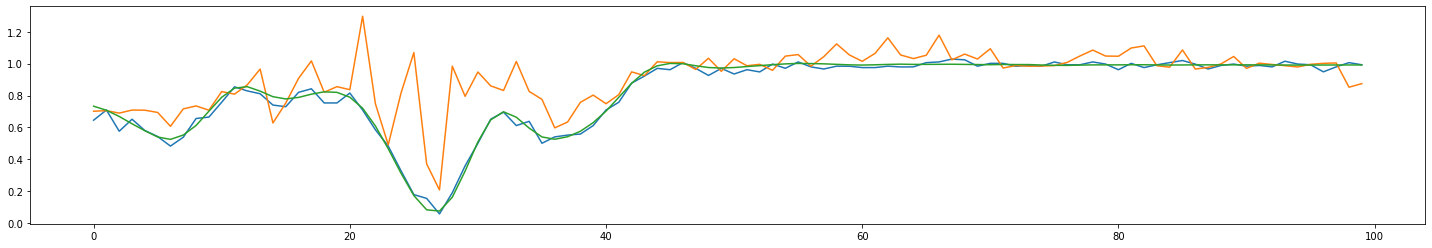

In [29]:
plt.figure(figsize=(25, 4))
plt.plot(exp_data[100:200])
plt.plot(deno_exp_data[100:200])
plt.plot(exp_data_deno[100:200])
plt.show()

In [30]:
# Px
data_length = 2*512
num_iter = len(exp_data) // data_length

deno_exp_data = []
model.eval()
for idx in range(num_iter):
    patch_data = exp_data[idx*data_length:(idx+1)*data_length].reshape(2, -1)
    with torch.no_grad():
        deno_patch = model(torch.FloatTensor(np.expand_dims(patch_data, 0)).cuda()).cpu().numpy().flatten()
        deno_exp_data += list(deno_patch)
deno_exp_data = np.array(deno_exp_data)

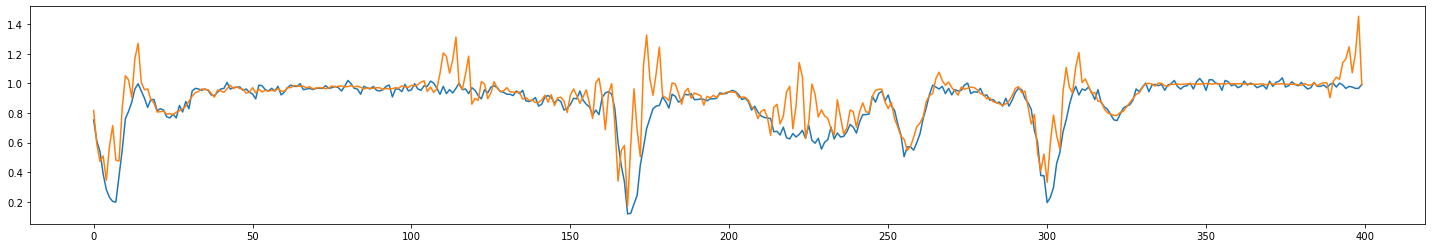

In [31]:
plt.figure(figsize=(25, 4))
plt.plot(exp_data[1600:2000])
plt.plot(deno_exp_data[1600:2000])
# plt.plot(exp_data_deno[100:200])
plt.show()

In [28]:
folder_name = "result_6"
res_A = np.load(f'./data/models/{folder_name}/total_N32_A_idx.npy')
res_raw = np.load(f'./data/models/{folder_name}/total_N32_raw_pred.npy').T
res_deno = np.load(f'./data/models/{folder_name}/total_N32_deno_pred.npy').T

print(len(res_A))

torch.Size([262144, 2, 512])